# Intro
CNNs are designed to handle spatial information, whereas RNNs are ideal for handling sequential information, such text data or non-stationary financial time-series data.

Part 1 of this exercise explores some NLP concepts using H.G. Wells' The Time Machine as an example.

Part 2 then uses this dataset to create a character-level language RNN model.

Part 3 shows the creation of the same RNN model in Part 2 but from scratch. The performance and predictive power is noticeably worse.

# Part 1: Text Preprocessing and Reading in the Data
This novella is rather short at ~30000 words. The following function reads the dataset into a list of text lines, where each line is a string. Punctuation and capitalization are ignored.

In [2]:
import collections
from d2l import torch as d2l
import re

#@save
d2l.DATA_HUB['time_machine'] = (d2l.DATA_URL + 'timemachine.txt',
                                '090b5e7e70c295757f55df93cb0a180b9691891a')

def read_time_machine():  #@save
    """Load the time machine dataset into a list of text lines."""
    with open(d2l.download('time_machine'), 'r') as f:
        lines = f.readlines()
    return [re.sub('[^A-Za-z]+', ' ', line).strip().lower() for line in lines]

lines = read_time_machine()
print(f'# text lines: {len(lines)}')
print(lines[0])
print(lines[10])

# text lines: 3221
the time machine by h g wells
twinkled and his usually pale face was flushed and animated the


# Tokenization
Tokenization is the process of splitting each text sequence into "tokens", which is a basic unit of text (with data type string).

In [3]:
def tokenize(lines, token='word'):  #@save
    """Split text lines into word or character tokens."""
    if token == 'word':
        return [line.split() for line in lines]
    elif token == 'char':
        return [list(line) for line in lines]
    else:
        print('ERROR: unknown token type: ' + token)

tokens = tokenize(lines)
for i in range(11):
    print(tokens[i])

['the', 'time', 'machine', 'by', 'h', 'g', 'wells']
[]
[]
[]
[]
['i']
[]
[]
['the', 'time', 'traveller', 'for', 'so', 'it', 'will', 'be', 'convenient', 'to', 'speak', 'of', 'him']
['was', 'expounding', 'a', 'recondite', 'matter', 'to', 'us', 'his', 'grey', 'eyes', 'shone', 'and']
['twinkled', 'and', 'his', 'usually', 'pale', 'face', 'was', 'flushed', 'and', 'animated', 'the']


# Vocabulary
A "vocabulary", also known as a "dictionary", maps string tokens to numerical indices starting from 0. This done by counting the unique tokens in all the documents from the training set (the "corpus"), and then assigning a numerical index to each unique token according to its frequency (lower-frequency or appearing tokens are excluded/ignored).

Any token that does not exist in the corpus or has been removed is mapped to a special unknown token "unk". A list of reserved tokens, such as "pad" for padding, "bos" to present the beginning for a sequence, and "eos" for the end of a sequence, are added but are not crucial.

In [4]:
class Vocab:  #@save
    """Vocabulary for text."""
    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = [] 
        # Sort according to frequencies
        counter = count_corpus(tokens)
        self.token_freqs = sorted(counter.items(), key=lambda x: x[0])
        self.token_freqs.sort(key=lambda x: x[1], reverse=True)
        # The index for the unknown token is 0
        self.unk, uniq_tokens = 0, ['<unk>'] + reserved_tokens
        uniq_tokens += [token for token, freq in self.token_freqs
                        if freq >= min_freq and token not in uniq_tokens]
        self.idx_to_token, self.token_to_idx = [], dict()
        for token in uniq_tokens:
            self.idx_to_token.append(token)
            self.token_to_idx[token] = len(self.idx_to_token) - 1

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]

def count_corpus(tokens):  #@save
    """Count token frequencies."""
    # Here `tokens` is a 1D list or 2D list
    if len(tokens) == 0 or isinstance(tokens[0], list):
        # Flatten a list of token lists into a list of tokens
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)

Construct a vocabulary using the time machine dataset as the corpus, and print the first few frequent tokens with their indices.

In [5]:
vocab = Vocab(tokens)
print(list(vocab.token_to_idx.items())[:10])

[('<unk>', 0), ('the', 1), ('i', 2), ('and', 3), ('of', 4), ('a', 5), ('to', 6), ('was', 7), ('in', 8), ('that', 9)]


Convert each text line into a list of numerical indices.

In [6]:
for i in [0, 10]:
    print('words:', tokens[i])
    print('indices:', vocab[tokens[i]])

words: ['the', 'time', 'machine', 'by', 'h', 'g', 'wells']
indices: [1, 19, 50, 40, 3130, 3058, 438]
words: ['twinkled', 'and', 'his', 'usually', 'pale', 'face', 'was', 'flushed', 'and', 'animated', 'the']
indices: [4399, 3, 25, 1398, 387, 113, 7, 1676, 3, 1053, 1]


# Extracting Information
Everything is packaged in the load_corpus_time_machine function, which returns the corpus, a list of token indices, and vocab (the vocabulary of the time machine corpus). Note the following:
1) Text is tokenized into characters, not words, to simplify the training.
2) The corpus is a single list, not a list of token lists, since each text line in the time machine dataset is not necessarily a sentence or a paragraph.

In [16]:
def load_corpus_time_machine(max_tokens=-1):  #@save
    """Return token indices and the vocabulary of the time machine dataset."""
    lines = read_time_machine()
    tokens = tokenize(lines, 'char')
    vocab = Vocab(tokens)
    # Since each text line in the time machine dataset is not necessarily a
    # sentence or a paragraph, flatten all the text lines into a single list
    corpus = [vocab[token] for line in tokens for token in line]
    if max_tokens > 0:
        corpus = corpus[:max_tokens]
    return corpus, vocab

corpus, vocab = load_corpus_time_machine()
print("Length of corups and vocab lists:", len(corpus),",", len(vocab))

tokens = d2l.tokenize(d2l.read_time_machine())
# Since each text line is not necessisarily a sentence or a paragraph, we
# concatenate all text lines 
corpus = [token for line in tokens for token in line]
vocab = d2l.Vocab(corpus)
print("Ten most frequent words:", vocab.token_freqs[:10])

Length of corups and vocab lists: 170580 , 28
Ten most frequent words: [('the', 2261), ('i', 1267), ('and', 1245), ('of', 1155), ('a', 816), ('to', 695), ('was', 552), ('in', 541), ('that', 443), ('my', 440)]


Plot word frequency.

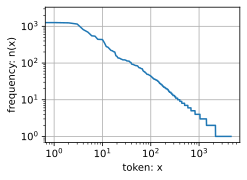

In [17]:
freqs = [freq for token, freq in vocab.token_freqs]
d2l.plot(freqs, xlabel='token: x', ylabel='frequency: n(x)',
         xscale='log', yscale='log')

Note that the word frequency decays rapidly in a well-defined way. This follows Zipf's Law. Consider other word combinations, such as bigrams and trigrams.

In [18]:
bigram_tokens = [pair for pair in zip(corpus[:-1], corpus[1:])]
bigram_vocab = d2l.Vocab(bigram_tokens)
bigram_vocab.token_freqs[:10]

[(('of', 'the'), 309),
 (('in', 'the'), 169),
 (('i', 'had'), 130),
 (('i', 'was'), 112),
 (('and', 'the'), 109),
 (('the', 'time'), 102),
 (('it', 'was'), 99),
 (('to', 'the'), 85),
 (('as', 'i'), 78),
 (('of', 'a'), 73)]

Out of the ten most frequent word pairs, nine are composed of both stop words and only one is relevant to the actual book: "the time". Let's see if the trigram frequency behaves similarly.

In [19]:
trigram_tokens = [triple for triple in zip(
    corpus[:-2], corpus[1:-1], corpus[2:])]
trigram_vocab = d2l.Vocab(trigram_tokens)
trigram_vocab.token_freqs[:10]

[(('the', 'time', 'traveller'), 59),
 (('the', 'time', 'machine'), 30),
 (('the', 'medical', 'man'), 24),
 (('it', 'seemed', 'to'), 16),
 (('here', 'and', 'there'), 15),
 (('it', 'was', 'a'), 15),
 (('i', 'did', 'not'), 14),
 (('seemed', 'to', 'me'), 14),
 (('i', 'began', 'to'), 13),
 (('i', 'saw', 'the'), 13)]

Finally, visualize the token frequency among these three models: unigrams, bigrams, and trigrams.

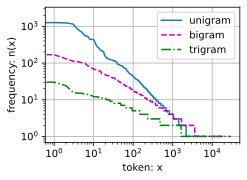

In [20]:
bigram_freqs = [freq for token, freq in bigram_vocab.token_freqs]
trigram_freqs = [freq for token, freq in trigram_vocab.token_freqs]
d2l.plot([freqs, bigram_freqs, trigram_freqs], xlabel='token: x',
         ylabel='frequency: n(x)', xscale='log', yscale='log',
         legend=['unigram', 'bigram', 'trigram'])

# Part 2: Character-Level Language RNN Model
We will train an RNN model on The Time Machine data.

In [21]:
batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

# Defining the Model
Construct the recurrent neural network layer "rnn_layer" with a single hidden layer and 256 hidden units. Multiple layers simply amount to the output of one layer of RNN being used as the input for the next layer of RNN.

In [39]:
num_hiddens = 256
rnn_layer = nn.RNN(len(vocab), num_hiddens)

Use a tensor to initialize the hidden state, whose shape is (number of hidden layers, batch size, number of hidden units).

In [40]:
state = torch.zeros((1, batch_size, num_hiddens))
state.shape

torch.Size([1, 32, 256])

In [41]:
# compute the output of the updated hidden state
X = torch.rand(size=(num_steps, batch_size, len(vocab)))
Y, state_new = rnn_layer(X, state)
Y.shape, state_new.shape

(torch.Size([35, 32, 256]), torch.Size([1, 32, 256]))

Define an "RNNModel" class for a complete RNN model. Note that "rnn_layer" only contains the hidden recurrent layers, so the output layer needs to be created separately.

In [42]:
#@save
class RNNModel(nn.Module):
    """The RNN model."""
    def __init__(self, rnn_layer, vocab_size, **kwargs):
        super(RNNModel, self).__init__(**kwargs)
        self.rnn = rnn_layer
        self.vocab_size = vocab_size
        self.num_hiddens = self.rnn.hidden_size
        # If the RNN is bidirectional (to be introduced later),
        # `num_directions` should be 2, else it should be 1.
        if not self.rnn.bidirectional:
            self.num_directions = 1
            self.linear = nn.Linear(self.num_hiddens, self.vocab_size)
        else:
            self.num_directions = 2
            self.linear = nn.Linear(self.num_hiddens * 2, self.vocab_size)

    def forward(self, inputs, state):
        X = F.one_hot(inputs.T.long(), self.vocab_size)
        X = X.to(torch.float32)
        Y, state = self.rnn(X, state)
        # The fully connected layer will first change the shape of `Y` to
        # (`num_steps` * `batch_size`, `num_hiddens`). Its output shape is
        # (`num_steps` * `batch_size`, `vocab_size`).
        output = self.linear(Y.reshape((-1, Y.shape[-1])))
        return output, state

    def begin_state(self, device, batch_size=1):
        if not isinstance(self.rnn, nn.LSTM):
            # `nn.GRU` takes a tensor as hidden state
            return  torch.zeros((self.num_directions * self.rnn.num_layers,
                                 batch_size, self.num_hiddens), 
                                device=device)
        else:
            # `nn.LSTM` takes a tuple of hidden states
            return (torch.zeros((
                self.num_directions * self.rnn.num_layers,
                batch_size, self.num_hiddens), device=device),
                    torch.zeros((
                        self.num_directions * self.rnn.num_layers,
                        batch_size, self.num_hiddens), device=device))

# Training and Predicting
Before training the model, let's make a prediction with the a model that has random weights. The prediction function we'll define will generate new characters following the user-provided prefix, which is a string containing several characters.

In [43]:
device = d2l.try_gpu()
model = RNNModel(rnn_layer, vocab_size=len(vocab))
model = model.to(device)
d2l.predict_ch8('time traveller', 10, model, vocab, device)

'time travellerfgqhqhqhqh'

Obviously, the model doesn't work at all, so let's train it.

perplexity 1.3, 280007.8 tokens/sec on cuda:0
time traveller he dais the medical man there are ballook bur fou
traveller pot sor himens and ly has inthing i ge aly was ch


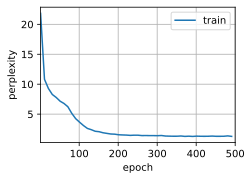

In [44]:
num_epochs, lr = 500, 1
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

perplexity 1.6, 344138.6 tokens/sec on cuda:0
time travellerit s against reason said filbycan a cube that this
travellerit s against reason said filby of course a solid b


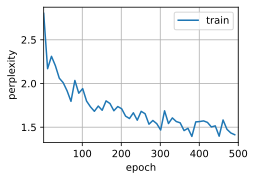

In [45]:
train_ch8(model, train_iter, vocab, lr, num_epochs, d2l.try_gpu(),
          use_random_iter=True)

Try the same prediction again.

In [46]:
predict_ch8('time traveller ', 10, model, vocab, d2l.try_gpu())

'time traveller proceeded '

# Part 3: Bonus: Implement RNN from Scratch
The model constructed in Part 2 was achieved using a high-level API, which turns out to be faster and more efficient.

# One-Hot Encoding
The tokens in we extracted in Part 1 will be treated as feature vectors, which we'll feed into the RNN. These feature vectors will be represented by one-hot encoding, which maps each index (token) to a unit vector.

In [24]:
from d2l import torch as d2l
import math
import torch
from torch import nn
from torch.nn import functional as F

F.one_hot(torch.tensor([0, 2]), len(vocab))

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0]])

The shape of the minibatch that sampled each time is (batch size, number of time steps). The "one_hot" function transforms a minibatch into a 3D tensor, where the last dimension equals the vocabulary size (len(vocab)). Transposing the input helps to obtain an output of shape (number of time steps, batch size, vocabulary size). This will allow us to more conveniently loop through the outermost dimension for updating hidden states of a minibatch, time step by time step.

In [25]:
X = d2l.reshape(torch.arange(10), (2, 5))
F.one_hot(X.T, 28).shape

torch.Size([5, 2, 28])

# Intializing RNN Model Parameters
The number of hidden units "num_hiddens" is a tunable hyperparameter. When training language models, the inputs and outputs are from the same vocabulary. Hence, they have the same dimension, which is equal to the vocabulary size.

In [26]:
def get_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01

    # Hidden layer parameters
    W_xh = normal((num_inputs, num_hiddens))
    W_hh = normal((num_hiddens, num_hiddens))
    b_h = torch.zeros(num_hiddens, device=device)
    # Output layer parameters
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    # Attach gradients
    params = [W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

# RNN Model
To define an RNN model, we first need an "init_rnn_state" function to return the hidden state at initialization. The function returns a tensor filled with 0 and with a shape of (batch size, number of hidden units). 

In [27]:
def init_rnn_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device), )

The activation function uses the tanh function. The "rnn" function defines how to compute the hidden state and output at a time step. The RNN model loops through the outermost dimension of inputs so that it updates hidden states H of a minibatch, time step by time step.

In [28]:
def rnn(inputs, state, params):
    # Here `inputs` shape: (`num_steps`, `batch_size`, `vocab_size`)
    W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    # Shape of `X`: (`batch_size`, `vocab_size`)
    for X in inputs:
        H = torch.tanh(torch.mm(X, W_xh) + torch.mm(H, W_hh) + b_h)
        Y = torch.mm(H, W_hq) + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H,)

Create a class to wrap these functions and store parameters for an RNN model implemented from scratch.

In [29]:
class RNNModelScratch: #@save
    """A RNN Model implemented from scratch."""
    def __init__(self, vocab_size, num_hiddens, device,
                 get_params, init_state, forward_fn):
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.params = get_params(vocab_size, num_hiddens, device)
        self.init_state, self.forward_fn = init_state, forward_fn

    def __call__(self, X, state):
        X = F.one_hot(X.T, self.vocab_size).type(torch.float32)
        return self.forward_fn(X, state, self.params)

    def begin_state(self, batch_size, device):
        return self.init_state(batch_size, self.num_hiddens, device)

Check whether the outputs have the correct shapes (ensure that the dimensionality of the hidden state remains unchanged).

In [30]:
num_hiddens = 512
model = RNNModelScratch(len(vocab), num_hiddens, d2l.try_gpu(), get_params,
                        init_rnn_state, rnn)
state = model.begin_state(X.shape[0], d2l.try_gpu())
Y, new_state = model(X.to(d2l.try_gpu()), state)
Y.shape, len(new_state), new_state[0].shape

(torch.Size([10, 28]), 1, torch.Size([2, 512]))

The output shape is (number of time steps  ×  batch size, vocabulary size), while the hidden state shape remains the same: (batch size, number of hidden units).

# Pre-Train Prediction
The prediction function we'll define will generate new characters following the user-provided prefix, which is a string containing several characters.

In [31]:
def predict_ch8(prefix, num_preds, model, vocab, device):  #@save
    """Generate new characters following the `prefix`."""
    state = model.begin_state(batch_size=1, device=device)
    outputs = [vocab[prefix[0]]]
    get_input = lambda: d2l.reshape(torch.tensor(
        [outputs[-1]], device=device), (1, 1))
    for y in prefix[1:]:  # Warm-up period
        _, state = model(get_input(), state)
        outputs.append(vocab[y])
    for _ in range(num_preds):  # Predict `num_preds` steps
        y, state = model(get_input(), state)
        outputs.append(int(y.argmax(dim=1).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])

Test the "predict_ch8" function. We specify the prefix as "time traveller" and have it generate 10 additional characters. Note that since we have not trained the network, it will generate nonsensical predictions.

In [32]:
predict_ch8('time traveller ', 10, model, vocab, d2l.try_gpu())

'time traveller tqdddddddd'

# Gradient Clipping
Gradient clipping is a technique to prevent exploding gradients in RNNs, which tend to have many layers. Sometimes the gradients can be large and the optimization algorithm may fail to converge. Below, the gradient norm is computed over all the model parameters.

In [33]:
def grad_clipping(model, theta):  #@save
    """Clip the gradient."""
    if isinstance(model, nn.Module):
        params = [p for p in model.parameters() if p.requires_grad]
    else:
        params = model.params
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

# Training


In [34]:
def train_epoch_ch8(model, train_iter, loss, updater, device,  #@save
                    use_random_iter):
    """Train a model within one epoch (defined in Chapter 8)."""
    state, timer = None, d2l.Timer()
    metric = d2l.Accumulator(2)  # Sum of training loss, no. of tokens
    for X, Y in train_iter:
        if state is None or use_random_iter:
            # Initialize `state` when either it is the first iteration or
            # using random sampling
            state = model.begin_state(batch_size=X.shape[0], device=device)
        else:
            if isinstance(model, nn.Module) and not isinstance(state, tuple):
                # `state` is a tensor for `nn.GRU`
                state.detach_()
            else:
                # `state` is a tuple of tensors for `nn.LSTM` and
                # for our custom scratch implementation 
                for s in state:
                    s.detach_()
        y = Y.T.reshape(-1)
        X, y = X.to(device), y.to(device)
        y_hat, state = model(X, state)
        l = loss(y_hat, y.long()).mean()
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            grad_clipping(model, 1)
            updater.step()
        else:
            l.backward()
            grad_clipping(model, 1)
            # Since the `mean` function has been invoked
            updater(batch_size=1)
        metric.add(l * d2l.size(y), d2l.size(y))
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()

The training function supports an RNN model implemented either from scratch or using high-level APIs.

In [35]:
#@save
def train_ch8(model, train_iter, vocab, lr, num_epochs, device,
              use_random_iter=False):
    """Train a model (defined in Chapter 8)."""
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', ylabel='perplexity',
                            legend=['train'], xlim=[1, num_epochs])
    # Initialize
    if isinstance(model, nn.Module):
        updater = torch.optim.SGD(model.parameters(), lr)
    else:
        updater = lambda batch_size: d2l.sgd(model.params, lr, batch_size)
    predict = lambda prefix: predict_ch8(prefix, 50, model, vocab, device)
    # Train and predict
    for epoch in range(num_epochs):
        ppl, speed = train_epoch_ch8(
            model, train_iter, loss, updater, device, use_random_iter)
        if epoch % 10 == 0:
            print(predict('time traveller'))
            animator.add(epoch + 1, [ppl])
    print(f'perplexity {ppl:.1f}, {speed:.1f} tokens/sec on {str(device)}')
    print(predict('time traveller'))
    print(predict('traveller'))

Now train the RNN model. Since we only use 10000 tokens in the dataset, the model needs more epochs to converge better.

perplexity 1.0, 87843.1 tokens/sec on cuda:0
time travelleryou can show black is white by argument said filby
travelleryou can show black is white by argument said filby


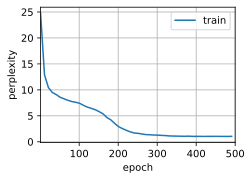

In [36]:
num_epochs, lr = 500, 1
train_ch8(model, train_iter, vocab, lr, num_epochs, d2l.try_gpu())

Check the results of using the random sampling method.

perplexity 1.4, 81985.9 tokens/sec on cuda:0
time traveller held in his hand was a glitteringmetallic framewo
travellerit s against reason said filbywhac upty he slitht 


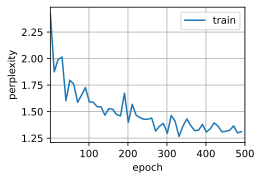

In [37]:
train_ch8(model, train_iter, vocab, lr, num_epochs, d2l.try_gpu(),
          use_random_iter=True)

We can also quickly check the same prediction as above, now that the model is trained.

In [38]:
predict_ch8('time traveller ', 10, model, vocab, d2l.try_gpu())

'time traveller held in hi'

This model is noticeably worse than that built in Part 2.